In [197]:
import findspark
from pyspark.sql import SparkSession
import pyspark
import random
import numpy as np
import pandas as pd
import pmdarima as pm
import matplotlib.pyplot as plt
from pandas import Series
from pandas.plotting import scatter_matrix
from statsmodels.tsa.stattools import acf, pacf  
from pyspark.sql import functions as F
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA 
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.model_selection import train_test_split
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
#from pandas.plotting import register 
#register_matplotlibmaters_conplers_conplers_conplers_conplats_conplers_conplers_conplats_conplats_convers
%matplotlib notebook

findspark.init()

### Chargement du fichier

In [198]:
df_NO2 = pd.read_csv("BC_interpolated.csv")

### Date max et min

In [199]:
#df_NO2 = df_NO2.drop_duplicates()
print('Time period start: {}\nTime period end: {}'.format(df_NO2.time.min(),df_NO2.time.max()))

Time period start: 2019-11-18 09:05:50+00:00
Time period end: 2019-11-22 10:21:00+00:00


### Data Preprocessing and Visualization

In [200]:
#Définition de l'index sur la colonne time pour faciliter les manipulations :
df_NO2["time"]=pd.to_datetime(df_NO2["time"])
df_NO2 = df_NO2.sort_values(by=["time"])
df_NO2 = df_NO2.set_index("time")

In [201]:
#Tri des valeurs par ordre croissant sur la colonne time
df_NO2 = df_NO2.sort_values(by = 'time')

In [202]:
#En-tête du dataframe
df_NO2.head()

BC_filtered
time                                  
2019-11-18 09:05:50+00:00       1468.0
2019-11-18 09:06:20+00:00       1378.0
2019-11-18 09:06:50+00:00       1378.0
2019-11-18 09:07:20+00:00       1498.0
2019-11-18 09:07:50+00:00       1498.0

In [203]:
#Compter le nombre de valeurs nulles
df_NO2.isnull().sum()

BC_filtered    104
dtype: int64

In [204]:
#df_NO2_fill = df_NO2.fillna(df_NO2.bfill())

In [211]:
#Compter le nombre total de valeur de la colonne NO2_filtered
df_NO2['BC_filtered'].count()

1448

In [206]:
#Dernières valeyrs du dataframe
df_NO2.tail()

BC_filtered
time                                  
2019-11-22 10:19:00+00:00          NaN
2019-11-22 10:19:30+00:00          NaN
2019-11-22 10:20:00+00:00          NaN
2019-11-22 10:20:30+00:00          NaN
2019-11-22 10:21:00+00:00          NaN

<IPython.core.display.Javascript object>


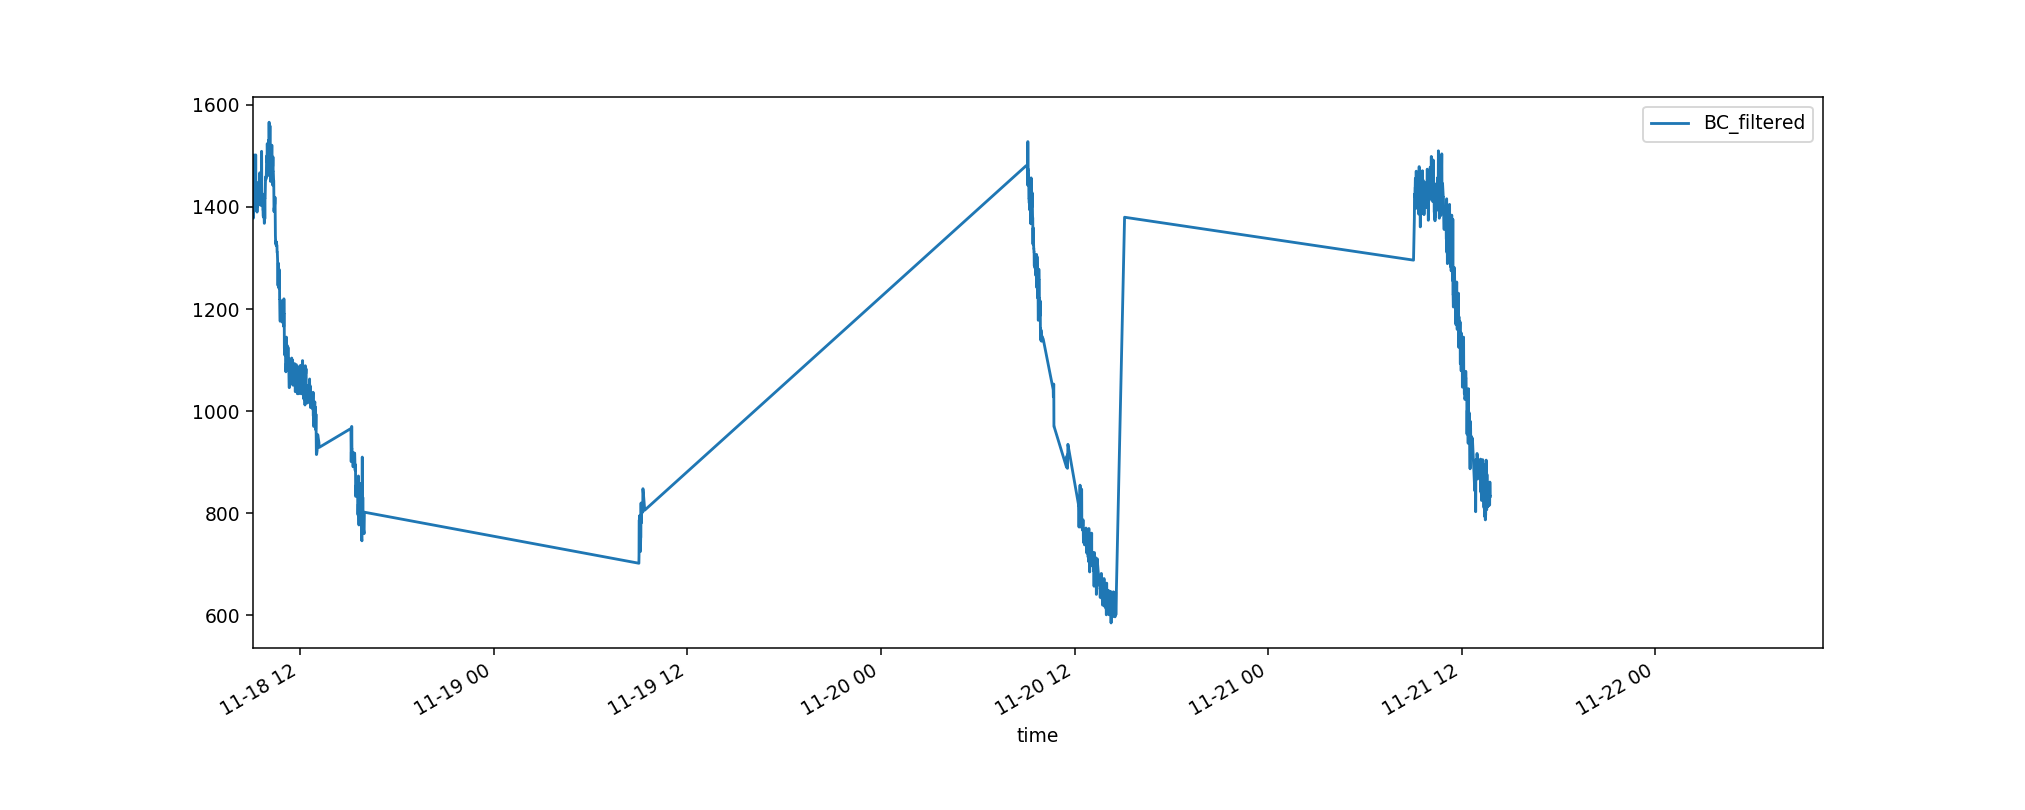

In [207]:
#Ploting des données brutes
df_NO2.plot(figsize=(15, 6))
plt.show()

In [208]:
#On ferme le plt pour ne pas que l'exécution d'un secon plot s'affiche la figure précédente
plt.close()

<IPython.core.display.Javascript object>


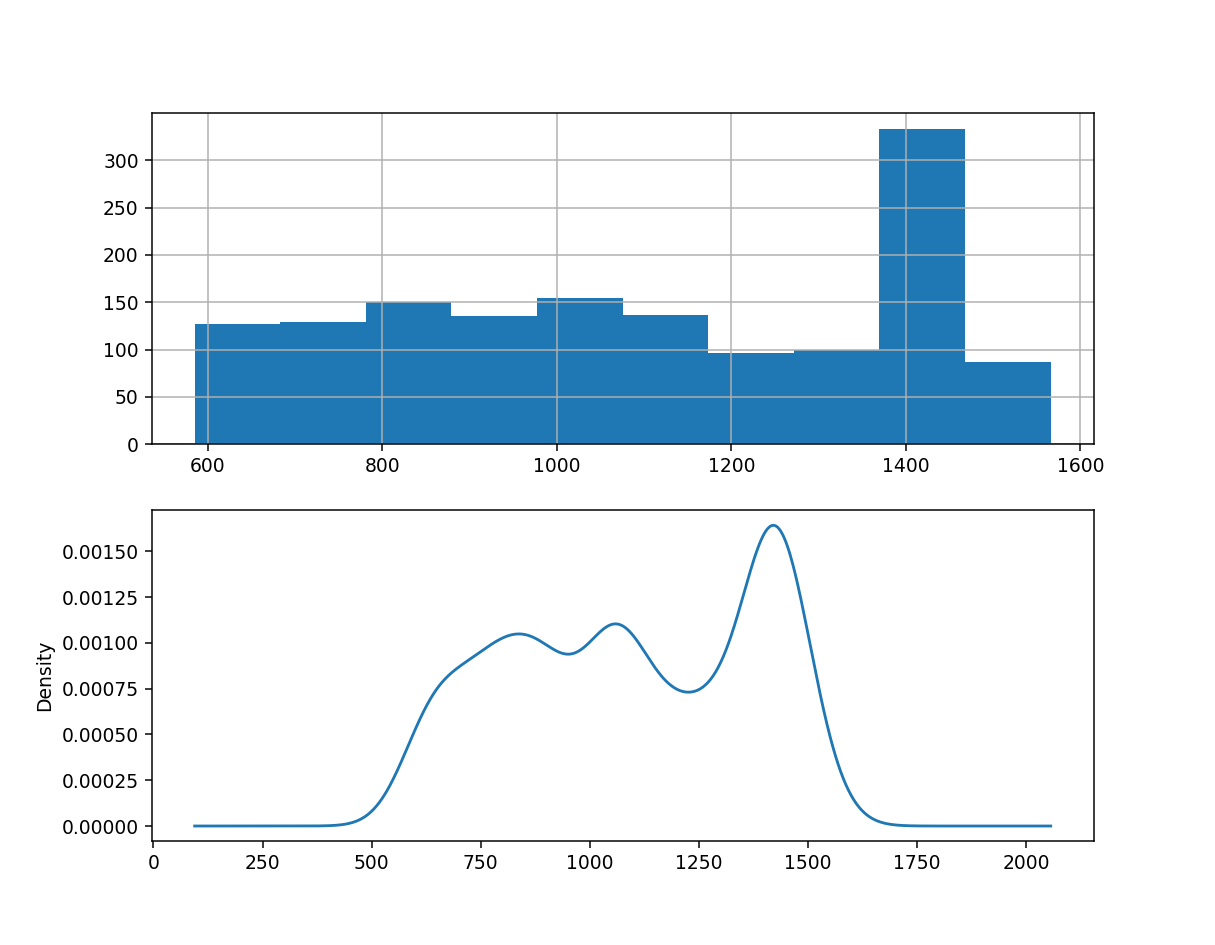

In [212]:
#Faisons un examen des graphiques de la densité des observations permettant de mieux comprendre la structure des données :

pyplot.figure(1)
pyplot.subplot(211)
df_NO2.BC_filtered.hist()
pyplot.subplot(212)
df_NO2.BC_filtered.plot(kind='kde')
pyplot.show()

In [213]:
plt.close()

In [214]:
#On remplace les valeurs nulles par les méthodes Forward filling et backward filling
#df_NO2_fill1 = df_NO2.fillna(method="ffill")
#df_NO2_fill1

In [215]:
#df_NO2_fill2 = df_NO2.fillna(method="bfill")

In [216]:
#df_NO2_fill2

In [217]:
#On affiche graphiquement les valeurs avec les valeurs nulles remplacées
#fig = plt.figure(figsize=(9,9))
#plt.subplot(7, 1, 1)
#plt.plot(df_NO2["NO2_filtered"])
#plt.title("NO2_filtered")

#plt.subplot(7, 1, 2)
#plt.plot(df_NO2_fill1)
#plt.title("NO2 fill forward")

#plt.subplot(7, 1, 3)
#plt.plot(df_NO2_fill2)
#plt.title("NO2 fill backward ")

#fig.tight_layout()
#plt.show()

In [218]:
plt.close()

### stationary

<IPython.core.display.Javascript object>


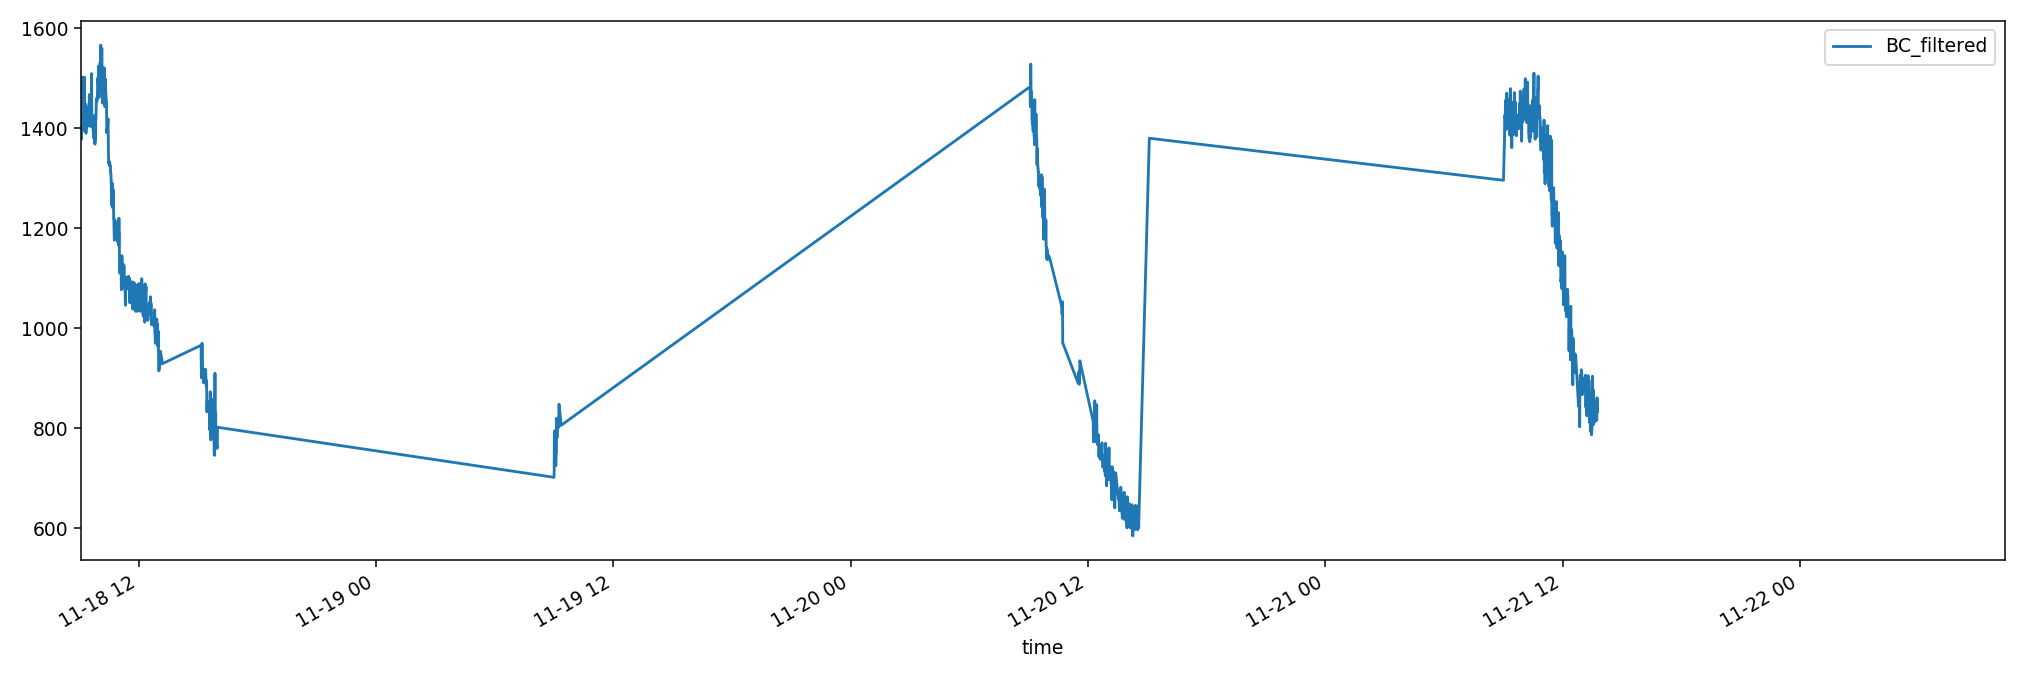

In [219]:
#On affiche le graphique de la méthode choisie qui est fill backward
df_NO2.plot(figsize=(15, 5))
plt.tight_layout()
plt.show()

In [220]:
#On supprime les NaN restantes à la fin du dataframe pour pouvoir faire l'autocorrélation
df_NO2 = df_NO2.dropna()

<IPython.core.display.Javascript object>


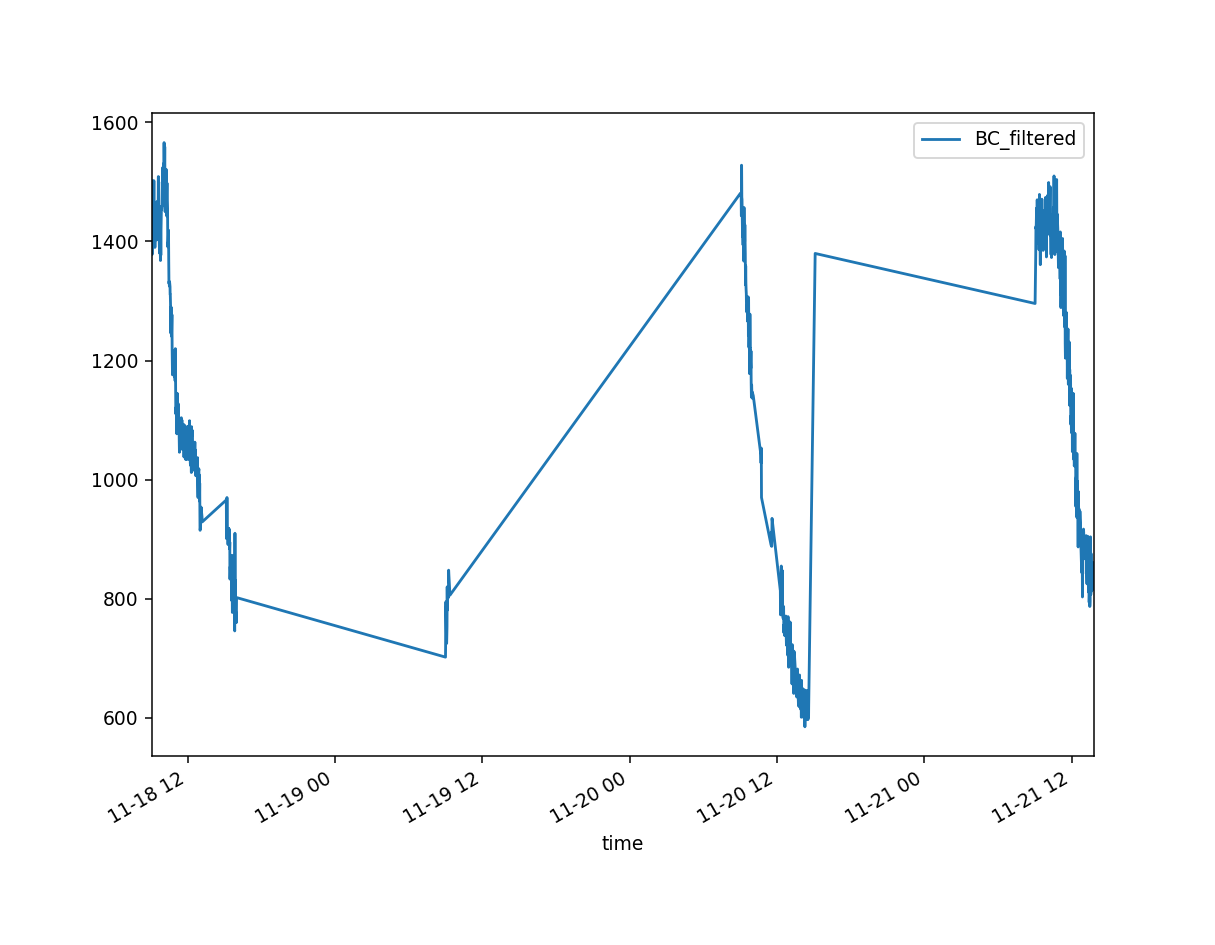

In [222]:
#On affiche le graphique après suppression des valeurs nulles
df_NO2.plot()

In [223]:
plt.close()

<IPython.core.display.Javascript object>


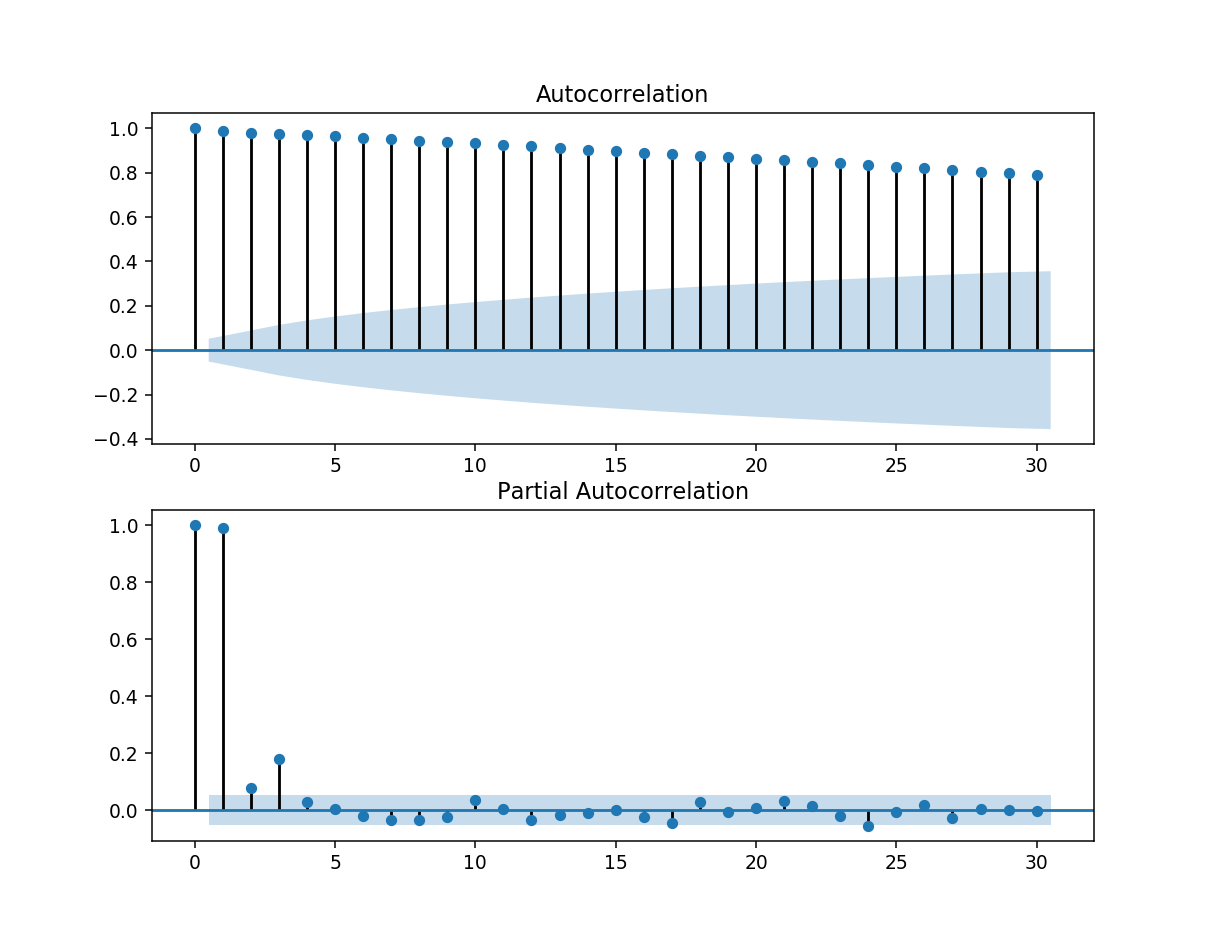

In [224]:
#ACF and PACF plots avec la série non stationnaire

pyplot.figure()
pyplot.subplot(211)
plot_acf(df_NO2, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(df_NO2, ax=pyplot.gca(), lags = 30)
pyplot.show()

In [225]:
plt.close()

In [227]:
##On teste la stationarité des données propres (débruitée et dédoublonnées) avec la méthode Augmented Dickey-Fuller Test (ADF Test)

result = adfuller(df_NO2.BC_filtered.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.045582502535898
p-value: 0.26695107584467037
Critial Values:
   1%, -3.434886677803751
Critial Values:
   5%, -2.8635436366589673
Critial Values:
   10%, -2.5678367211155533


In [228]:
#Nous remarquons dans le résultat ci-dessus que la p-value est largement supérieure au seuil 0.05 donc la série n'est pas stationnaire

In [229]:
plt.close()

<IPython.core.display.Javascript object>


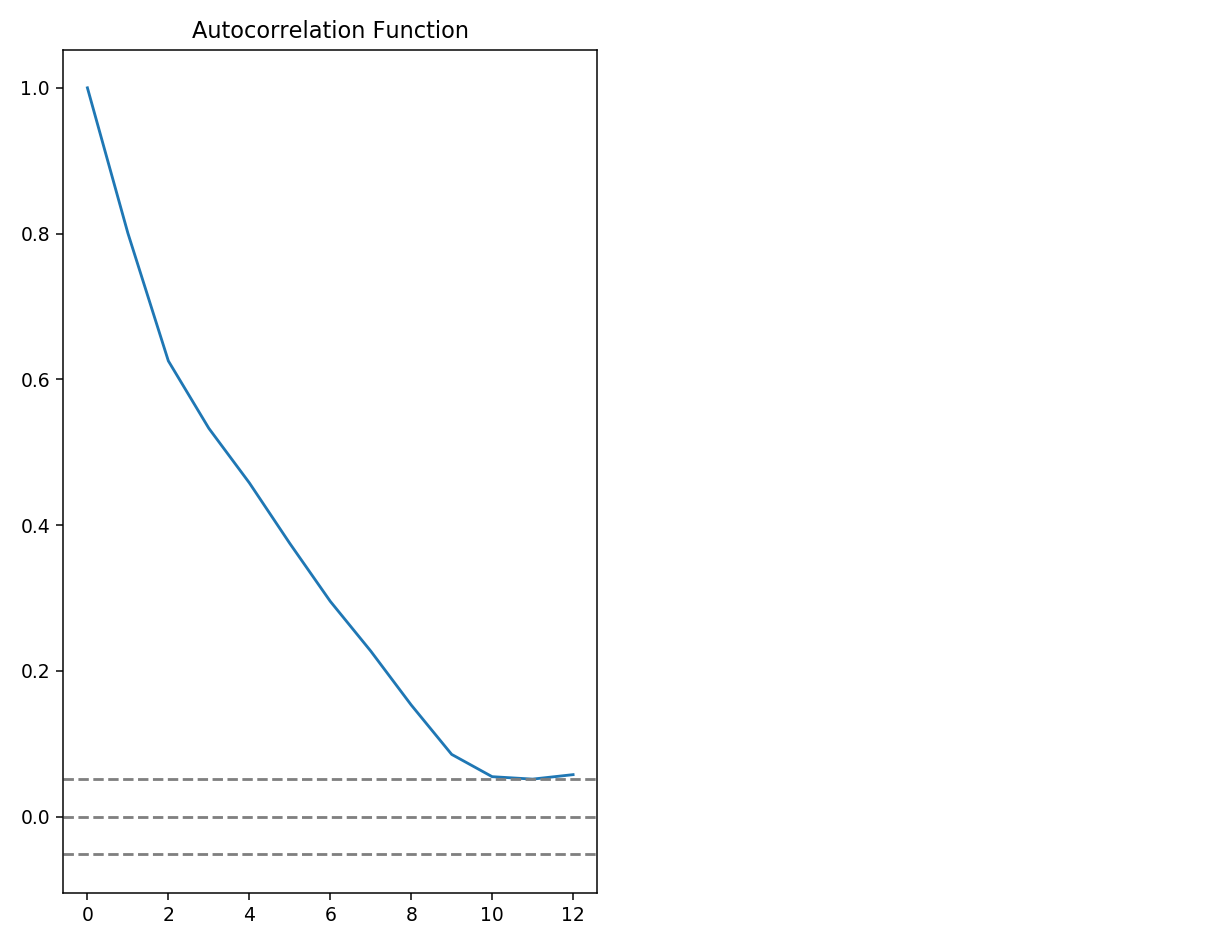

In [231]:
##On peut également tester la stationarité des données propres (débruitée et dédoublonnées) avec la méthode Rolling Statistics


df_NO2.plot()
rolling_mean.rename(columns={'NO2_filtered': 'NO2_filtered_mean'}, inplace=True)
rolling_std.rename(columns={'NO2_filtered': 'NO2_filtered_std'}, inplace=True)
plt.plot ( rolling_mean, color = 'red', label = 'Rolling Mean') 
plt.plot (rolling_std, color = 'black', label = 'Rolling Std') 
plt.legend (loc = 'best') 
plt.title ('Rolling Écart type moyen et glissant ')
plt.show ()

In [232]:
#Comme vous pouvez le voir ci-dessus la moyenne mobile et l'écart-type roulant augmentent avec le temps. Par conséquent, nous pouvons conclure que la série chronologique n'est pas stationnaire

#Rendons la série stationnaire

Deux raisons majeures expliquent la non-stationnarité d'une TS :

Tendance - moyenne variable dans le temps. Par exemple, dans le cas présent, nous avons vu qu'en moyenne, le nombre de passagers augmentait au fil du temps.
Saisonnalité - variations à des périodes spécifiques. Par exemple, les gens peuvent avoir tendance à acheter une voiture au cours d'un mois donné en raison d'une augmentation de salaire ou de festivals.

Transformations
Nous pouvons appliquer des transformations qui pénalisent davantage les valeurs élevées que les valeurs plus faibles. Il peut s'agir de prendre un logarithme, une racine carrée, une racine cubique, etc. Prenons ici une transformation logarithmique pour plus de simplicité et pour réduire la vitesse à laquelle la moyenne mobile augmente.

In [235]:
df_logNO2 = np.log(df_NO2['BC_filtered'])
plt.plot(df_logNO2)

In [236]:
df_logNO2.head()

time
2019-11-18 09:05:50+00:00    7.291656
2019-11-18 09:06:20+00:00    7.228388
2019-11-18 09:06:50+00:00    7.228388
2019-11-18 09:07:20+00:00    7.311886
2019-11-18 09:07:50+00:00    7.311886
Name: BC_filtered, dtype: float64

#Créons une fonction pour exécuter le test qui détermine si une série temporelle donnée est stationnaire.

In [237]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
     #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [238]:
#Il existe plusieurs transformations que nous pouvons appliquer à une série chronologique pour la rendre stationnaire. Par exemple, nous soustrayons la moyenne mobile.

rolling_mean = df_logNO2.rolling(window=12).mean()
df_logNO2_minus_mean = df_logNO2 - rolling_mean
df_logNO2_minus_mean.dropna(inplace=True)
get_stationarity(df_logNO2_minus_mean)

Results of Dickey-Fuller Test:
Test Statistic                -8.099507e+00
p-value                        1.311373e-12
#Lags Used                     1.100000e+01
Number of Observations Used    1.425000e+03
Critical Value (1%)           -3.434947e+00
Critical Value (5%)           -2.863570e+00
Critical Value (10%)          -2.567851e+00
dtype: float64


In [239]:
#Nous remarquons dans le résultat ci-dessus que la p-value est largement inférieure au seuil 0.05 donc la série est stationnaire

In [240]:
#En-tête des données différenciées
df_logNO2_minus_mean.head()

time
2019-11-18 09:11:30+00:00    0.017753
2019-11-18 09:12:00+00:00   -0.007642
2019-11-18 09:12:30+00:00   -0.011713
2019-11-18 09:13:00+00:00   -0.015152
2019-11-18 09:13:30+00:00   -0.012323
Name: BC_filtered, dtype: float64

In [241]:
#Supprimons les valeurs nulles 
df_logNO2_minus_mean.dropna()

time
2019-11-18 09:11:30+00:00    0.017753
2019-11-18 09:12:00+00:00   -0.007642
2019-11-18 09:12:30+00:00   -0.011713
2019-11-18 09:13:00+00:00   -0.015152
2019-11-18 09:13:30+00:00   -0.012323
                               ...   
2019-11-21 13:43:30+00:00   -0.015666
2019-11-21 13:44:00+00:00    0.033234
2019-11-21 13:44:30+00:00    0.028556
2019-11-21 13:45:10+00:00   -0.006427
2019-11-21 13:45:40+00:00   -0.006728
Name: BC_filtered, Length: 1437, dtype: float64

### Time Series forecasting

<IPython.core.display.Javascript object>


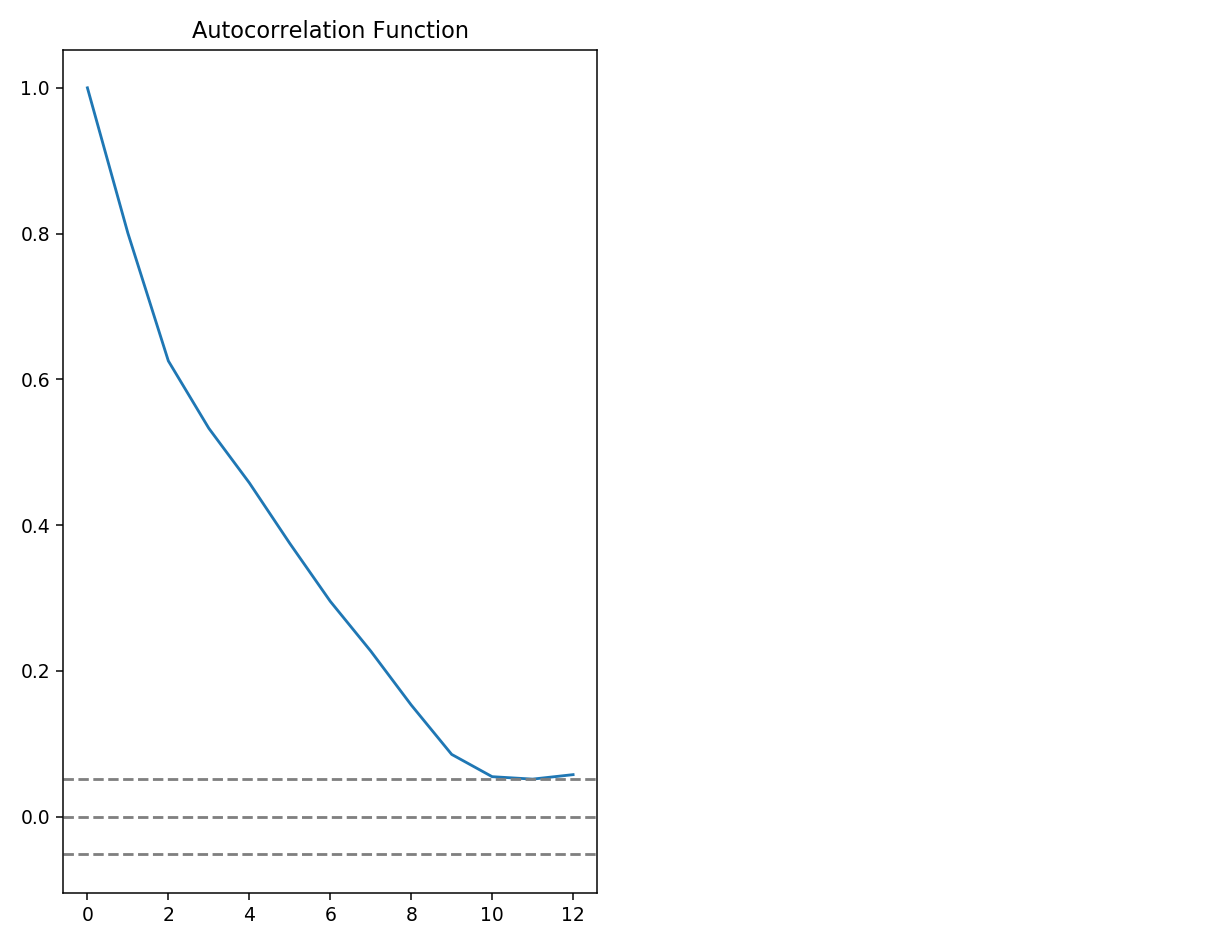

In [242]:
#ACF and PACF plots avec la série  stationnaire

pyplot.figure()
pyplot.subplot(211)
plot_acf(df_logNO2_minus_mean, ax=pyplot.gca(),lags=30)
pyplot.subplot(212)
plot_pacf(df_logNO2_minus_mean, ax=pyplot.gca(),lags=30)
pyplot.show()

In [251]:
#Affichons graphiquement les corrélations

lag_acf = acf(df_logNO2_minus_mean, nlags=12)
lag_pacf = pacf(df_logNO2_minus_mean, nlags=12, method='ols')

#Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_logNO2_minus_mean)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_logNO2_minus_mean)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_logNO2_minus_mean)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_logNO2_minus_mean)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

C:\Users\THOMAS\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


In [252]:
#Prédictions sur les données en utilisant 75% pour le train et 25% pour le test

train = df_logNO2_minus_mean[:int(0.75*(len(df_logNO2_minus_mean)))]
valid = df_logNO2_minus_mean[int(0.75*(len(df_logNO2_minus_mean))):]

#plotting the data
trainplot = plt.plot(train, color='red', label='Rolling Mean')
validplot = plt.plot(valid, color='black', label='Rolling Std')

In [253]:
print(train.size)
print(valid.size)

1077
360


In [254]:
plt.close()

In [255]:
#Construisons le modèle
model = pm.auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=-4079.073, BIC=-4049.181, Time=0.215 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=-2871.236, BIC=-2861.273, Time=0.143 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=-4074.758, BIC=-4059.812, Time=0.216 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-3600.213, BIC=-3585.268, Time=0.264 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=-2873.226, BIC=-2868.244, Time=0.064 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=-4081.043, BIC=-4056.133, Time=0.720 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=-3855.816, BIC=-3835.888, Time=0.817 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-4075.322, BIC=-4055.394, Time=0.115 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=-4079.201, BIC=-4049.310, Time=1.062 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=-

ARIMA(maxiter=50, method='lbfgs', order=(1, 0, 2), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

<IPython.core.display.Javascript object>


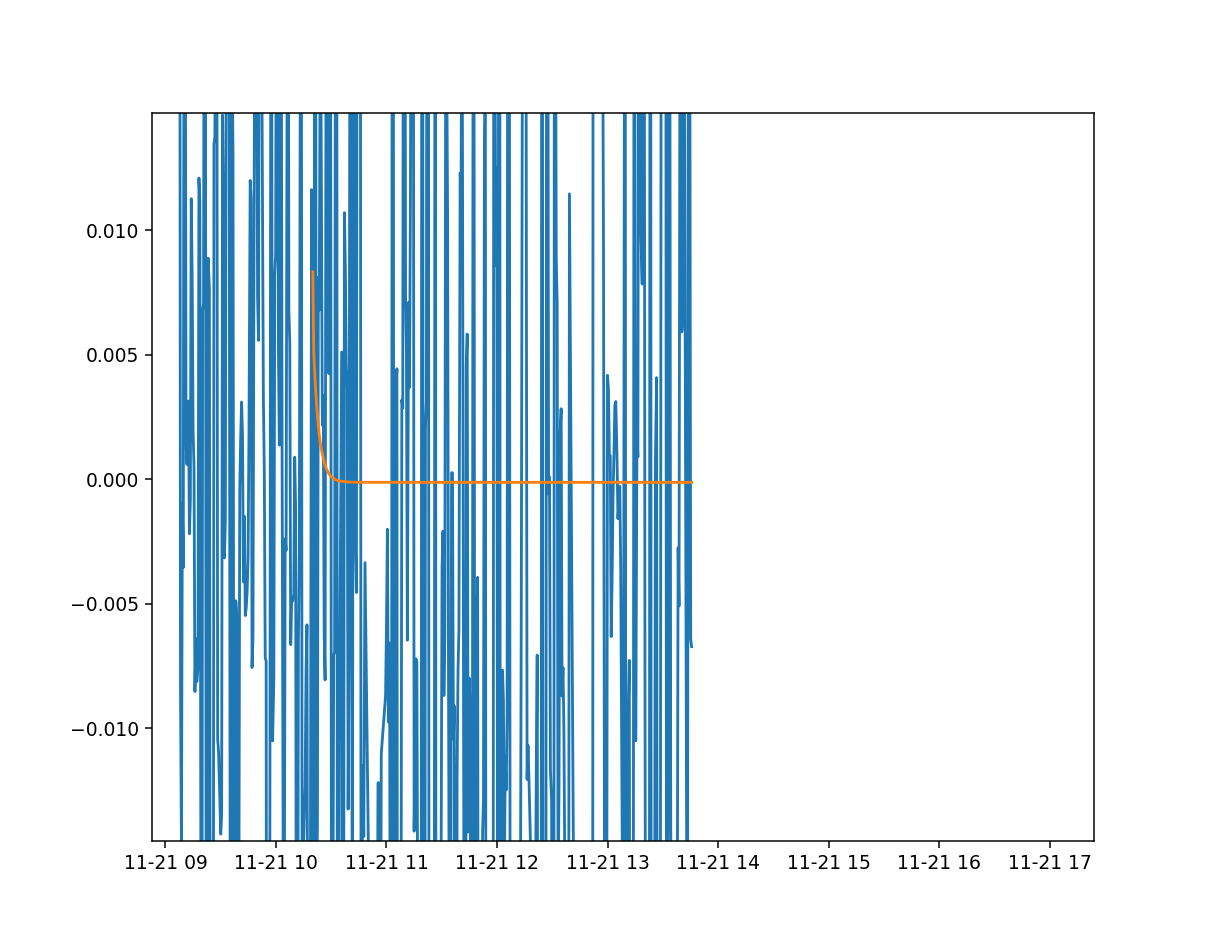

In [256]:
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#ploter les prédictions sur les données valides
plt.plot(df_logNO2_minus_mean, label='Train')
#plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

In [257]:
plt.close()

<IPython.core.display.Javascript object>


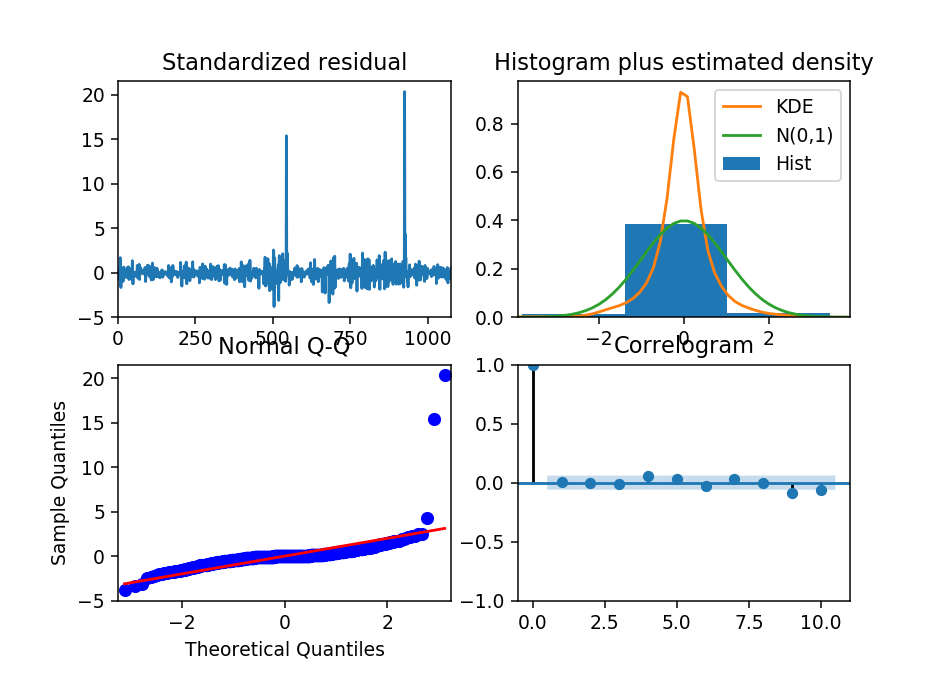

In [258]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

#Nous pouvons constater dans le rsultat ci-dessous : 

En haut à gauche : Les erreurs résiduelles semblent fluctuer autour d'une moyenne de zéro et ont une variance uniforme.

En haut à droite : Le graphique de la densité suggère une distribution normale avec une moyenne de zéro.

En bas à gauche : Tous les points devraient être parfaitement alignés avec la ligne rouge. Toute déviation significative impliquerait que la distribution est biaisée.

En bas à droite : Le graphique du corrélogramme, ou ACF, montre que les erreurs résiduelles ne sont pas autocorrélées. Toute autocorrélation impliquerait que les erreurs résiduelles présentent un certain schéma qui n'est pas expliqué dans le modèle.